In [1]:
import pandas as pd
import numpy as np
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
#random_states = random.sample(range(1, 100), 50)
random_states = [73, 62, 81, 4, 65, 10, 85, 3, 54, 9, 21, 13, 69, 52, 16, 96, 50, 8, 44, 92, 30, 56, 89, 86, 39, 70, 90, 17, 75, 49, 43, 45, 58, 22, 15, 80, 97, 66, 68, 55, 34, 63, 42, 12, 6, 29, 57, 25, 36, 41]
print(random_states)

[73, 62, 81, 4, 65, 10, 85, 3, 54, 9, 21, 13, 69, 52, 16, 96, 50, 8, 44, 92, 30, 56, 89, 86, 39, 70, 90, 17, 75, 49, 43, 45, 58, 22, 15, 80, 97, 66, 68, 55, 34, 63, 42, 12, 6, 29, 57, 25, 36, 41]


In [3]:
data = pd.read_csv("C:\\Users\\heich\\OneDrive\\Desktop\\me\\Thesis\\GD data\\FinalData.csv", delimiter=";")
#data = pd.read_csv("C:\\Users\\heich\\OneDrive\\Desktop\\me\\Thesis\\GD data\\FinalDataTypeA.csv", delimiter=";")
#data = pd.read_csv("C:\\Users\\heich\\OneDrive\\Desktop\\me\\Thesis\\GD data\\FinalData.csv", delimiter=";")

#data = pd.read_csv("C:\\Users\\heich\\OneDrive\\Desktop\\XGboost\\file1_dataFiltered.csv", delimiter=";")
#HomaData = pd.read_csv("C:\\Users\\heich\\OneDrive\\Desktop\\me\\Thesis\\GD data\\file1_dataFiltered_HOMAIR.csv", delimiter=",")

label_map = {'Case': 0, 'Control': 1}
data["Label"] = data["Label"].map(label_map)

x_values = data.iloc[:, 1:].values
y_values = data.iloc[:, 0].values

# x_values = np.delete(x_values, data['Glucose'], axis=1)


scaler = StandardScaler()
x_values = scaler.fit_transform(x_values)

mi_scores = mutual_info_regression(x_values, y_values,random_state= 42)

feature_names = data.columns[1:]

sorted_features = [f for _, f in sorted(zip(mi_scores, feature_names), reverse=True)]

In [4]:
data

,Label,Absolute Neutrophil count Auto# (ANC),Basophil Auto #,Basophil Auto %,Eosi0phil Auto #,Eosi0phil Auto %,Hct,Hgb,Lymphocyte Auto #,Lymphocyte Auto %,...,CRP,HbA1C %,Homocysteine Plasma LC-MSMS,HOMA-IR,WeightDifference,Biological Age,History of high glucose level/diabetes,Pregnancy Age,family history of Diabetes,HOMA-IR-GENERAL
0,0,4.3,0.0,0.5,0.1,1.4,35.2,11.9,2.0,28.8,...,7.0,4.3,5.0,0.043630,2.0,31,0,13,1,0.354667
1,0,3.8,0.0,0.5,0.2,2.5,32.7,11.6,2.1,30.9,...,36.0,4.3,5.0,0.065827,-8.0,28,1,14,1,2.176000
2,0,5.1,0.0,0.2,0.1,0.9,30.8,10.9,2.5,29.4,...,4.8,4.9,7.0,0.109358,0.0,27,0,12,1,0.204800
3,0,4.8,0.1,0.7,0.3,4.1,35.1,12.2,2.1,26.8,...,1.7,5.1,6.0,0.057086,3.0,20,1,15,1,0.086133
4,0,5.4,0.0,0.4,0.2,2.6,36.4,12.7,1.8,22.4,...,6.3,5.4,6.0,0.299160,3.0,39,1,17,1,0.299600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1,7.9,0.1,0.6,0.3,2.8,35.5,12.0,1.2,11.8,...,12.4,5.5,5.9,0.699259,6.0,43,0,14,1,0.633778
88,1,6.8,0.0,0.3,0.1,0.6,35.2,12.1,1.9,20.3,...,30.8,4.9,5.2,0.106889,3.0,29,0,23,1,1.752178
89,1,4.5,0.0,0.4,0.1,0.9,35.3,12.6,1.6,23.7,...,2.8,4.8,6.0,0.063827,-4.5,34,0,14,1,0.165511
90,1,3.6,0.0,0.6,0.1,1.9,35.9,12.6,1.2,22.3,...,8.0,5.0,7.0,0.668000,10.0,31,0,25,1,0.462222


In [5]:
print(sorted_features)
print("====================")
print(len(sorted_features))

['History of high glucose level/diabetes', 'NT pro-BNP', 'FT3', 'FT4', 'MCHC', 'Basophil Auto #', 'Eosi0phil Auto #', 'Fibri0gen', 'Urea', 'Lymphocyte Auto %', 'Insulin', 'Homocysteine Plasma LC-MSMS', 'Cholesterol', 'Calcium', 'Sodium', 'MPV', 'Alk Phos', 'Magnesium', 'Prothrombin Time', 'Basophil Auto %', 'LDL-Calc', 'Total Protein', 'HOMA-IR', 'ALT', 'WBC', 'CRP', 'Estradiol', 'Neutrophil Auto %', 'HDL', 'Ferritin', 'Uric Acid', 'C-Peptide', 'Creatinine', 'Mo0cyte Auto #', 'Absolute Neutrophil count Auto# (ANC)', 'Pregnancy Age', 'MCH', 'AST', 'family history of Diabetes', 'WeightDifference', 'Vit D', 'Vit B12', 'Triglyceride', 'Testo', 'TSH', 'TIBC', 'RBC', 'Potassium', 'Platelet', 'Phosphorus', 'Mo0cyte Auto %', 'MCV', 'Lymphocyte Auto #', 'Iron', 'Hgb', 'Hct', 'HbA1C %', 'HOMA-IR-GENERAL', 'Glucose', 'GGT', 'Folate', 'Eosi0phil Auto %', 'Chloride', 'Calcium Corr', 'CK', 'Biological Age', 'Bilirubin T', 'Bicarbonate', 'Albumin Lvl', 'APTT']
70


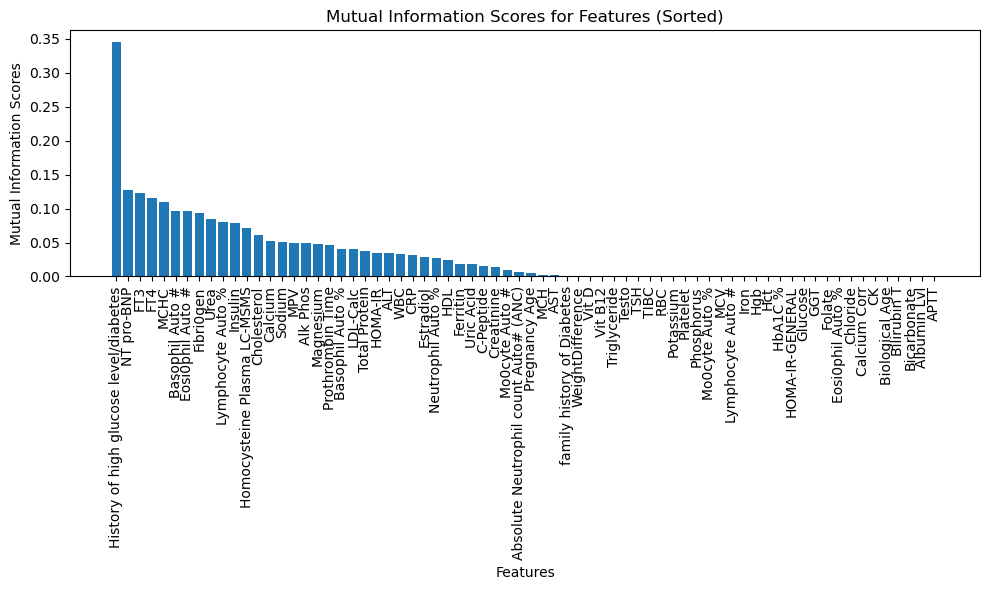

In [6]:
sorted_mi_scores = sorted(mi_scores, reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(sorted_features, sorted_mi_scores)
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information Scores')
plt.title('Mutual Information Scores for Features (Sorted)')
plt.tight_layout()
plt.show()

# Plotting FI for all features

In [7]:
All_Related_Features = sorted_features[:38]

print("Related features:", All_Related_Features)

Related features: ['History of high glucose level/diabetes', 'NT pro-BNP', 'FT3', 'FT4', 'MCHC', 'Basophil Auto #', 'Eosi0phil Auto #', 'Fibri0gen', 'Urea', 'Lymphocyte Auto %', 'Insulin', 'Homocysteine Plasma LC-MSMS', 'Cholesterol', 'Calcium', 'Sodium', 'MPV', 'Alk Phos', 'Magnesium', 'Prothrombin Time', 'Basophil Auto %', 'LDL-Calc', 'Total Protein', 'HOMA-IR', 'ALT', 'WBC', 'CRP', 'Estradiol', 'Neutrophil Auto %', 'HDL', 'Ferritin', 'Uric Acid', 'C-Peptide', 'Creatinine', 'Mo0cyte Auto #', 'Absolute Neutrophil count Auto# (ANC)', 'Pregnancy Age', 'MCH', 'AST']


In [8]:
important_features = All_Related_Features
data = data[['Label'] + important_features]
#data = pd.concat([data, HomaData['HOMA-IR-US'],HomaData['WeightDifference']], axis=1)
#data = pd.concat([data, HomaData['HOMA-IR-US']], axis=1)
#data = pd.concat([data, HomaData['HOMA-IR-GENERAL'],HomaData['WeightDifference']], axis=1)
#data = pd.concat([data, HomaData['HOMA-IR-GENERAL']], axis=1)
#data = pd.concat([data, HomaData['HOMA-IR-US'],HomaData['HOMA-IR-GENERAL'],HomaData['WeightDifference']], axis=1)
#data = pd.concat([data, HomaData['HOMA-IR-US'],HomaData['HOMA-IR-GENERAL']], axis=1)

In [9]:
data

,Label,History of high glucose level/diabetes,NT pro-BNP,FT3,FT4,MCHC,Basophil Auto #,Eosi0phil Auto #,Fibri0gen,Urea,...,HDL,Ferritin,Uric Acid,C-Peptide,Creatinine,Mo0cyte Auto #,Absolute Neutrophil count Auto# (ANC),Pregnancy Age,MCH,AST
0,0,0,100.4,3.64,13.4,33.9,0.0,0.1,4.5,2.9,...,1.3,52.0,212.0,1.17,49,0.5,4.3,13,28.6,15
1,0,1,21.7,3.84,10.7,35.6,0.0,0.2,5.1,1.8,...,1.4,46.0,155.0,0.83,43,0.7,3.8,14,32.4,14
2,0,0,29.0,4.00,15.0,35.5,0.0,0.1,3.1,1.7,...,1.9,11.7,175.0,2.37,32,0.7,5.1,12,28.6,11
3,0,1,40.0,4.70,18.4,34.9,0.1,0.3,3.7,2.1,...,1.8,7.2,195.0,1.49,33,0.6,4.8,15,26.2,16
4,0,1,49.0,4.60,10.3,35.0,0.0,0.2,4.3,2.3,...,1.9,29.4,255.0,3.32,39,0.5,5.4,17,27.2,12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1,0,62.0,4.00,12.8,33.7,0.1,0.3,4.0,2.2,...,1.3,26.1,148.0,6.19,34,0.6,7.9,14,28.2,18
88,1,0,37.0,4.90,11.1,34.4,0.0,0.1,7.7,1.3,...,1.5,98.1,180.0,1.29,36,0.5,6.8,23,27.5,18
89,1,0,41.0,3.90,16.5,35.8,0.0,0.1,3.5,2.9,...,1.7,17.9,184.0,1.36,59,0.5,4.5,14,31.1,15
90,1,0,39.0,4.20,12.8,35.0,0.0,0.1,4.9,2.8,...,1.6,25.4,250.0,7.93,44,0.6,3.6,25,28.4,10


In [ ]:
# Plot pair plot
sns.pairplot(data, hue='Label', diag_kind='kde', markers=['o', 's'], palette='husl')
plt.title('Pair Plot of Data')
plt.show()

# Create a correlation matrix
corr_matrix = data.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
#All_Related_Features = sorted_features[:39]
#data = data[['Label'] + All_Related_Features]

x_values = data.iloc[:, 1:].values
y_values = data.iloc[:, 0].values

scaler = StandardScaler()
x_values = scaler.fit_transform(x_values)

f1_scores = []

for num_features in range(1, len(All_Related_Features) + 1):
    selected_features = All_Related_Features[:num_features]

    x_subset = data[selected_features].values

    average_f1 = 0

    for random_state in random_states:
        base_models = [
            RandomForestClassifier(n_estimators=100, random_state=random_state),
            GradientBoostingClassifier(n_estimators=100, random_state=random_state),
            AdaBoostClassifier(n_estimators=100, random_state=random_state),
            DecisionTreeClassifier(random_state=random_state),
            LogisticRegression(max_iter=10000),
            SVC(probability=True),
            GaussianNB(),
            KNeighborsClassifier(),
            CatBoostClassifier(iterations=100, random_seed=random_state, verbose=False),
            XGBClassifier(random_state=random_state),
            LGBMClassifier(random_state=random_state)
    ]

        meta_model = LogisticRegression(max_iter=10000)

        x_train, x_test, y_train, y_test = train_test_split(x_subset, y_values, test_size=0.3, random_state=random_state)

        predictions = []

        for base_model in base_models:
            base_model.fit(x_train, y_train)
            y_pred_base = base_model.predict(x_test)
            predictions.append(y_pred_base)

        stacked_predictions = np.column_stack(predictions)

        meta_model.fit(stacked_predictions, y_test)

        y_pred_stacked = meta_model.predict(stacked_predictions)

        f1 = f1_score(y_test, y_pred_stacked)

        average_f1 += f1

    average_f1 /= len(random_states)
    f1_scores.append(average_f1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(All_Related_Features) + 1), f1_scores, marker='o')
plt.xlabel('Number of Features')
plt.ylabel('Average F1 Score')
plt.title('F1 Score vs. Number of Features')
plt.xticks(range(1, len(All_Related_Features) + 1))
plt.grid(True)
plt.show()

# Model Results using All related variables

In [ ]:
# Assuming data is your dataset
x_values = data.iloc[:, 1:].values
y_values = data.iloc[:, 0].values

scaler = StandardScaler()
x_values = scaler.fit_transform(x_values)

top_results = {}
average_accuracy = 0
average_precision = 0
average_recall = 0
average_f1 = 0
average_specificity = 0

for random_state in random_states:
    base_models = [
        RandomForestClassifier(n_estimators=100, random_state=random_state),
        GradientBoostingClassifier(n_estimators=100, random_state=random_state),
        AdaBoostClassifier(n_estimators=100, random_state=random_state),
        DecisionTreeClassifier(random_state=random_state),
        LogisticRegression(),
        SVC(probability=True),
        GaussianNB(),
        KNeighborsClassifier(),
        CatBoostClassifier(iterations=100, random_seed=random_state, verbose=False),
        XGBClassifier(random_state=random_state),
        LGBMClassifier(random_state=random_state)
    ]

    meta_model = LogisticRegression()
    
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, random_state=random_state)

    predictions = []

    for base_model in base_models:
        base_model.fit(x_train, y_train)
        y_pred_base = base_model.predict(x_test)
        predictions.append(y_pred_base)

    stacked_predictions = np.column_stack(predictions)

    meta_model.fit(stacked_predictions, y_test)

    y_pred_stacked = meta_model.predict(stacked_predictions)

    accuracy = accuracy_score(y_test, y_pred_stacked)
    average_accuracy += accuracy

    confusion_mat = confusion_matrix(y_test, y_pred_stacked)
    tn, fp, fn, tp = confusion_mat.ravel()

    specificity = tn / (tn + fp)
    recall = recall_score(y_test, y_pred_stacked)
    precision = precision_score(y_test, y_pred_stacked)
    f1 = f1_score(y_test, y_pred_stacked)

    average_recall += recall
    average_precision += precision
    average_f1 += f1
    average_specificity += specificity

    top_results[random_state] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'specificity': specificity}

average_accuracy /= len(random_states)
average_precision /= len(random_states)
average_recall /= len(random_states)
average_f1 /= len(random_states)
average_specificity /= len(random_states)

print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall (Sn):", average_recall)
print("Average Specificity (Sp):", average_specificity)
print("Average F1-score:", average_f1)

# Each model using all related variables

In [ ]:
x_values = data.iloc[:, 1:].values
y_values = data.iloc[:, 0].values

scaler = StandardScaler()
x_values = scaler.fit_transform(x_values)

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    
    return accuracy, precision, recall, f1, specificity

base_models = [
    RandomForestClassifier(n_estimators=100, random_state=random_states[0]),
    GradientBoostingClassifier(n_estimators=100, random_state=random_states[0]),
    AdaBoostClassifier(n_estimators=100, random_state=random_states[0]),
    DecisionTreeClassifier(random_state=random_states[0]),
    LogisticRegression(max_iter=10000),
    SVC(probability=True),
    GaussianNB(),
    KNeighborsClassifier(),
    CatBoostClassifier(iterations=100, random_seed=random_states[0], verbose=False),
    XGBClassifier(random_state=random_states[0]),
    LGBMClassifier(random_state=random_states[0])
]

for base_model in base_models:
    print(f"Results for {base_model.__class__.__name__}:\n")

    average_metrics = {
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'specificity': 0
    }

    x_subset = x_values

    metrics_sum = {key: 0 for key in average_metrics}

    for random_state in random_states:
        meta_model = LogisticRegression(max_iter=10000)

        x_train, x_test, y_train, y_test = train_test_split(x_subset, y_values, test_size=0.3, random_state=random_state)

        base_model.fit(x_train, y_train)
        y_pred_base = base_model.predict(x_test)

        stacked_predictions = y_pred_base.reshape(-1, 1)  # Reshape to column vector

        meta_model.fit(stacked_predictions, y_test)

        y_pred_stacked = meta_model.predict(stacked_predictions)

        metrics = calculate_metrics(y_test, y_pred_stacked)

        for i, key in enumerate(average_metrics):
            metrics_sum[key] += metrics[i]

    for key in average_metrics:
        average_metrics[key] = metrics_sum[key] / len(random_states)

    # Print results
    print(f"Average Accuracy: {average_metrics['accuracy']:.4f}")
    print(f"Average Precision: {average_metrics['precision']:.4f}")
    print(f"Average Recall: {average_metrics['recall']:.4f}")
    print(f"Average F1 Score: {average_metrics['f1']:.4f}")
    print(f"Average Specificity: {average_metrics['specificity']:.4f}\n")

    print("="*40 + "\n")


# Model Results using Top 22 selected variables

In [10]:
Top_Selected= sorted_features[:22]

print("Related features:", Top_Selected)

Related features: ['History of high glucose level/diabetes', 'NT pro-BNP', 'FT3', 'FT4', 'MCHC', 'Basophil Auto #', 'Eosi0phil Auto #', 'Fibri0gen', 'Urea', 'Lymphocyte Auto %', 'Insulin', 'Homocysteine Plasma LC-MSMS', 'Cholesterol', 'Calcium', 'Sodium', 'MPV', 'Alk Phos', 'Magnesium', 'Prothrombin Time', 'Basophil Auto %', 'LDL-Calc', 'Total Protein']


In [11]:
important_features = Top_Selected
data2 = data[['Label'] + important_features]
data2

,Label,History of high glucose level/diabetes,NT pro-BNP,FT3,FT4,MCHC,Basophil Auto #,Eosi0phil Auto #,Fibri0gen,Urea,...,Cholesterol,Calcium,Sodium,MPV,Alk Phos,Magnesium,Prothrombin Time,Basophil Auto %,LDL-Calc,Total Protein
0,0,0,100.4,3.64,13.4,33.9,0.0,0.1,4.5,2.9,...,6.5,2.32,132,8.3,52,0.78,12.4,0.5,4.39,72
1,0,1,21.7,3.84,10.7,35.6,0.0,0.2,5.1,1.8,...,4.2,2.32,137,8.3,65,0.79,15.3,0.5,2.46,73
2,0,0,29.0,4.00,15.0,35.5,0.0,0.1,3.1,1.7,...,7.6,2.07,137,7.3,49,0.69,12.2,0.2,4.70,64
3,0,1,40.0,4.70,18.4,34.9,0.1,0.3,3.7,2.1,...,5.7,2.21,136,10.3,53,0.71,13.7,0.7,3.10,64
4,0,1,49.0,4.60,10.3,35.0,0.0,0.2,4.3,2.3,...,5.9,2.10,136,8.7,40,0.64,11.2,0.4,2.80,63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87,1,0,62.0,4.00,12.8,33.7,0.1,0.3,4.0,2.2,...,5.3,2.40,139,8.3,59,0.68,11.0,0.6,2.80,69
88,1,0,37.0,4.90,11.1,34.4,0.0,0.1,7.7,1.3,...,5.6,2.30,133,7.9,81,0.66,11.3,0.3,3.00,64
89,1,0,41.0,3.90,16.5,35.8,0.0,0.1,3.5,2.9,...,5.2,2.45,134,9.4,45,0.72,10.8,0.4,3.00,75
90,1,0,39.0,4.20,12.8,35.0,0.0,0.1,4.9,2.8,...,7.5,2.29,135,9.0,48,0.66,10.1,0.6,4.30,60


In [14]:
x_values = data2.iloc[:, 1:].values
y_values = data2.iloc[:, 0].values

scaler = StandardScaler()
x_values = scaler.fit_transform(x_values)

top_results = {}
average_accuracy = 0
average_precision = 0
average_recall = 0
average_f1 = 0
average_specificity = 0
average_auc = 0

for random_state in random_states:
    base_models = [
        RandomForestClassifier(n_estimators=100, random_state=random_state),
        GradientBoostingClassifier(n_estimators=100, random_state=random_state),
        AdaBoostClassifier(n_estimators=100, random_state=random_state),
        DecisionTreeClassifier(random_state=random_state),
        LogisticRegression(),
        SVC(probability=True),
        GaussianNB(),
        KNeighborsClassifier(),
        CatBoostClassifier(iterations=100, random_seed=random_state, verbose=False),
        XGBClassifier(random_state=random_state),
        LGBMClassifier(random_state=random_state)
    ]

    meta_model = LogisticRegression()
    
    x_train, x_test, y_train, y_test = train_test_split(x_values, y_values, test_size=0.3, random_state=random_state)

    predictions = []

    for base_model in base_models:
        base_model.fit(x_train, y_train)
        y_pred_base = base_model.predict(x_test)
        predictions.append(y_pred_base)

    stacked_predictions = np.column_stack(predictions)

    meta_model.fit(stacked_predictions, y_test)

    y_pred_stacked = meta_model.predict(stacked_predictions)

    accuracy = accuracy_score(y_test, y_pred_stacked)
    average_accuracy += accuracy

    confusion_mat = confusion_matrix(y_test, y_pred_stacked)
    tn, fp, fn, tp = confusion_mat.ravel()

    specificity = tn / (tn + fp)
    recall = recall_score(y_test, y_pred_stacked)
    precision = precision_score(y_test, y_pred_stacked)
    f1 = f1_score(y_test, y_pred_stacked)

    average_recall += recall
    average_precision += precision
    average_f1 += f1
    average_specificity += specificity
    
     # AUC calculation
    stacked_probabilities = meta_model.predict_proba(stacked_predictions)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, stacked_probabilities)
    auc = roc_auc_score(y_test, stacked_probabilities)
    top_results[random_state] = {'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1': f1, 'specificity': specificity, 'auc': auc}
    average_auc += auc

average_accuracy /= len(random_states)
average_precision /= len(random_states)
average_recall /= len(random_states)
average_f1 /= len(random_states)
average_specificity /= len(random_states)
average_auc/= len(random_states)


print("Average Accuracy:", average_accuracy)
print("Average Precision:", average_precision)
print("Average Recall (Sn):", average_recall)
print("Average Specificity (Sp):", average_specificity)
print("Average F1-score:", average_f1)
print("Average AUC:", average_auc)


[LightGBM] [Info] Number of positive: 40, number of negative: 24
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625000 -> initscore=0.510826
[LightGBM] [Info] Start training from score 0.510826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 38, number of negative: 26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 30, number of negative: 34
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.468750 -> initscore=-0.125163
[LightGBM] [Info] Start training from score -0.125163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

[LightGBM] [Info] Number of positive: 34, number of negative: 30
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531250 -> initscore=0.125163
[LightGBM] [Info] Start training from score 0.125163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 33, number of negative: 31
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515625 -> initscore=0.062520
[LightGBM] [Info] Start training from score 0.062520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 40, number of negative: 24
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 339
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.625000 -> initscore=0.510826
[LightGBM] [Info] Start training from score 0.510826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 36, number of negative: 28
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562500 -> initscore=0.251314
[LightGBM] [Info] Start training from score 0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 39, number of negative: 25
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 337
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.609375 -> initscore=0.444686
[LightGBM] [Info] Start training from score 0.444686
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 35, number of negative: 29
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546875 -> initscore=0.188052
[LightGBM] [Info] Start training from score 0.188052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 34, number of negative: 30
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531250 -> initscore=0.125163
[LightGBM] [Info] Start training from score 0.125163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 34, number of negative: 30
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 320
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531250 -> initscore=0.125163
[LightGBM] [Info] Start training from score 0.125163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 38, number of negative: 26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 36, number of negative: 28
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000109 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562500 -> initscore=0.251314
[LightGBM] [Info] Start training from score 0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 35, number of negative: 29
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546875 -> initscore=0.188052
[LightGBM] [Info] Start training from score 0.188052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 37, number of negative: 27
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000096 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.578125 -> initscore=0.315081
[LightGBM] [Info] Start training from score 0.315081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 35, number of negative: 29
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000095 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 326
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546875 -> initscore=0.188052
[LightGBM] [Info] Start training from score 0.188052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 37, number of negative: 27
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.578125 -> initscore=0.315081
[LightGBM] [Info] Start training from score 0.315081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 35, number of negative: 29
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 336
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546875 -> initscore=0.188052
[LightGBM] [Info] Start training from score 0.188052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 35, number of negative: 29
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 332
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546875 -> initscore=0.188052
[LightGBM] [Info] Start training from score 0.188052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 33, number of negative: 31
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 333
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.515625 -> initscore=0.062520
[LightGBM] [Info] Start training from score 0.062520
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 36, number of negative: 28
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 327
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.562500 -> initscore=0.251314
[LightGBM] [Info] Start training from score 0.251314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 38, number of negative: 26
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 328
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.593750 -> initscore=0.379490
[LightGBM] [Info] Start training from score 0.379490
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 37, number of negative: 27
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 330
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.578125 -> initscore=0.315081
[LightGBM] [Info] Start training from score 0.315081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 35, number of negative: 29
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 329
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.546875 -> initscore=0.188052
[LightGBM] [Info] Start training from score 0.188052
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

[LightGBM] [Info] Number of positive: 34, number of negative: 30
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 331
[LightGBM] [Info] Number of data points in the train set: 64, number of used features: 22
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.531250 -> initscore=0.125163
[LightGBM] [Info] Start training from score 0.125163
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

# each model seperatly using 22 variable

In [ ]:
x_values = data2.iloc[:, 1:].values
y_values = data2.iloc[:, 0].values

scaler = StandardScaler()
x_values = scaler.fit_transform(x_values)

def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0.0
    
    return accuracy, precision, recall, f1, specificity

base_models = [
    RandomForestClassifier(n_estimators=100, random_state=random_states[0]),
    GradientBoostingClassifier(n_estimators=100, random_state=random_states[0]),
    AdaBoostClassifier(n_estimators=100, random_state=random_states[0]),
    DecisionTreeClassifier(random_state=random_states[0]),
    LogisticRegression(max_iter=10000),
    SVC(probability=True),
    GaussianNB(),
    KNeighborsClassifier(),
    CatBoostClassifier(iterations=100, random_seed=random_states[0], verbose=False),
    XGBClassifier(random_state=random_states[0]),
    LGBMClassifier(random_state=random_states[0])
]

for base_model in base_models:
    print(f"Results for {base_model.__class__.__name__}:\n")

    average_metrics = {
        'accuracy': 0,
        'precision': 0,
        'recall': 0,
        'f1': 0,
        'specificity': 0
    }

    x_subset = x_values

    metrics_sum = {key: 0 for key in average_metrics}

    for random_state in random_states:
        meta_model = LogisticRegression(max_iter=10000)

        x_train, x_test, y_train, y_test = train_test_split(x_subset, y_values, test_size=0.3, random_state=random_state)

        base_model.fit(x_train, y_train)
        y_pred_base = base_model.predict(x_test)

        stacked_predictions = y_pred_base.reshape(-1, 1)  # Reshape to column vector

        meta_model.fit(stacked_predictions, y_test)

        y_pred_stacked = meta_model.predict(stacked_predictions)

        metrics = calculate_metrics(y_test, y_pred_stacked)

        for i, key in enumerate(average_metrics):
            metrics_sum[key] += metrics[i]

    for key in average_metrics:
        average_metrics[key] = metrics_sum[key] / len(random_states)

    # Print results
    print(f"Average Accuracy: {average_metrics['accuracy']:.4f}")
    print(f"Average Precision: {average_metrics['precision']:.4f}")
    print(f"Average Recall: {average_metrics['recall']:.4f}")
    print(f"Average F1 Score: {average_metrics['f1']:.4f}")
    print(f"Average Specificity: {average_metrics['specificity']:.4f}\n")

    print("="*40 + "\n")


# visualization 

In [ ]:
# Extracting metrics
accuracy_values = [result['accuracy'] for result in top_results.values()]
precision_values = [result['precision'] for result in top_results.values()]
recall_values = [result['recall'] for result in top_results.values()]
f1_values = [result['f1'] for result in top_results.values()]

# Creating a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Random State': list(top_results.keys()),
    'Accuracy': accuracy_values,
    'Precision': precision_values,
    'Recall': recall_values,
    'F1': f1_values
})

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(12, 8))

# Bar plot for Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Random State', y='Accuracy', data=results_df)
plt.title('Accuracy')

# Bar plot for Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Random State', y='Precision', data=results_df)
plt.title('Precision')

# Bar plot for Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Random State', y='Recall', data=results_df)
plt.title('Recall')

# Bar plot for F1 score
plt.subplot(2, 2, 4)
sns.barplot(x='Random State', y='F1', data=results_df)
plt.title('F1 Score')

plt.tight_layout()
plt.show()

In [ ]:
# Extracting metrics
accuracy_values = [result['accuracy'] for result in top_results.values()]
precision_values = [result['precision'] for result in top_results.values()]
recall_values = [result['recall'] for result in top_results.values()]
f1_values = [result['f1'] for result in top_results.values()]

# Creating a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Random State': list(top_results.keys()),
    'Accuracy': accuracy_values,
    'Precision': precision_values,
    'Recall': recall_values,
    'F1': f1_values
})

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(12, 8))

# Bar plot for Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Random State', data=results_df)  # Swap x and y
plt.title('Accuracy')

# Bar plot for Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Precision', y='Random State', data=results_df)  # Swap x and y
plt.title('Precision')

# Bar plot for Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Recall', y='Random State', data=results_df)  # Swap x and y
plt.title('Recall')

# Bar plot for F1 score
plt.subplot(2, 2, 4)
sns.barplot(x='F1', y='Random State', data=results_df)  # Swap x and y
plt.title('F1 Score')

plt.tight_layout()
plt.show()


In [ ]:
# Extracting metrics
accuracy_values = [result['accuracy'] for result in top_results.values()]
precision_values = [result['precision'] for result in top_results.values()]
recall_values = [result['recall'] for result in top_results.values()]
f1_values = [result['f1'] for result in top_results.values()]

# Creating a DataFrame for easy plotting
results_df = pd.DataFrame({
    'Random State': list(top_results.keys()),
    'Accuracy': accuracy_values,
    'Precision': precision_values,
    'Recall': recall_values,
    'F1': f1_values
})

# Set the style of seaborn
sns.set(style="whitegrid")

# Plotting
plt.figure(figsize=(12, 8))

# Bar plot for Accuracy
plt.subplot(2, 2, 1)
sns.barplot(x='Accuracy', y='Random State', data=results_df, orient='h')  # Set orient to 'h'
plt.title('Accuracy')

# Bar plot for Precision
plt.subplot(2, 2, 2)
sns.barplot(x='Precision', y='Random State', data=results_df, orient='h')  # Set orient to 'h'
plt.title('Precision')

# Bar plot for Recall
plt.subplot(2, 2, 3)
sns.barplot(x='Recall', y='Random State', data=results_df, orient='h')  # Set orient to 'h'
plt.title('Recall')

# Bar plot for F1 score
plt.subplot(2, 2, 4)
sns.barplot(x='F1', y='Random State', data=results_df, orient='h')  # Set orient to 'h'
plt.title('F1 Score')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'top_results' is the dictionary containing results for each random state

# Create a DataFrame for easy plotting
results_df = pd.DataFrame(top_results).T.reset_index()
results_df.columns = ['Random State', 'Accuracy', 'Precision', 'Recall', 'F1']

# Set the style of seaborn
sns.set(style="whitegrid")

# Melt the DataFrame for better visualization
melted_results = pd.melt(results_df, id_vars=['Random State'], var_name='Metric', value_name='Value')

# Plotting using box plots
plt.figure(figsize=(12, 8))
sns.boxplot(x='Metric', y='Value', data=melted_results, hue='Random State', palette='Set3')
plt.title('Performance Metrics Distribution Across Random States')
plt.legend(title='Random State', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming 'top_results' is the dictionary containing results for each random state

# Extracting metrics
average_accuracy = np.mean([result['accuracy'] for result in top_results.values()])
average_precision = np.mean([result['precision'] for result in top_results.values()])
average_recall = np.mean([result['recall'] for result in top_results.values()])
average_f1 = np.mean([result['f1'] for result in top_results.values()])

# Labels and values for the radar chart
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
values = [average_accuracy, average_precision, average_recall, average_f1]

# Number of metrics
num_metrics = len(labels)

# Compute angle of each axis
angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()

# Close the plot
values += values[:1]
angles += angles[:1]

# Plotting the radar chart
plt.figure(figsize=(8, 8))
plt.polar(angles, values, marker='o', linestyle='-', linewidth=2, color='b')
plt.fill(angles, values, alpha=0.4, color='b')

# Adding labels
plt.thetagrids(np.degrees(angles[:-1]), labels)
plt.title('Average Performance Metrics Across Random States')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'top_results' is the dictionary containing results for each random state

# Extracting metrics
average_accuracy = np.mean([result['accuracy'] for result in top_results.values()])
average_precision = np.mean([result['precision'] for result in top_results.values()])
average_recall = np.mean([result['recall'] for result in top_results.values()])
average_f1 = np.mean([result['f1'] for result in top_results.values()])

# Labels and values for the bar plot
labels = ['Accuracy', 'Precision', 'Recall', 'F1']
values = [average_accuracy, average_precision, average_recall, average_f1]

# Plotting the bar plot
plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['gray', 'gray', 'gray', 'gray'])
plt.xlabel('Performance Metrics')
plt.ylabel('Average Value')
plt.title('Average Performance Metrics Across Random States')

plt.show()
